# week 09 PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
! pip install pandas

In [2]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

In [ ]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = None  # YOUR CODE HERE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = None  # YOUR CODE HERE
y = None  # YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color="red")
plt.grid()

### Task 2: Using the Dataloader

In [3]:
from torch import nn
from torch.nn import functional as F

In [4]:
!wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py

--2024-02-15 18:34:30--  https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1799 (1.8K) [text/plain]
Saving to: ‘notmnist.py’

notmnist.py         100%[===================>]   1.76K  --.-KB/s    in 0s      

2024-02-15 18:34:30 (20.3 MB/s) - ‘notmnist.py’ saved [1799/1799]



In [5]:
! pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
from notmnist import load_notmnist


X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [7]:
print(Dataset.__doc__)

An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`. Subclasses could also
    optionally implement :meth:`__getitems__`, for speedup batched samples
    loading. This method accepts list of indices of samples of batch and returns
    list of samples.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs a index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    


In [8]:
import cv2

In [9]:
class DatasetMNIST(Dataset):
    def __init__(self, path="./notMNIST_small", letters="ABCDEFGHIJ", transform=None):
        self.data, self.labels, _, _ = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [10]:
full_dataset = DatasetMNIST("./notMNIST_small", "AB", transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [11]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [12]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

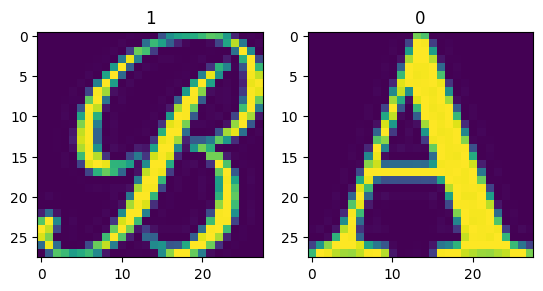

In [13]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [14]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=1)

We can use dataloader as iterator by using iter() function.

In [15]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [16]:
# # images, labels = train_iter.next()

# print("images shape on batch size = {}".format(images.size()))
# print("labels shape on batch size = {}".format(labels.size()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/miniconda3/envs/ml-mipt/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


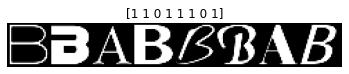

In [ ]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

And now with transformations:

In [17]:
train_dataset_with_transform = DatasetMNIST(transform=torchvision.transforms.ToTensor())

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [18]:
img, lab = train_dataset_with_transform.__getitem__(0)

print("image shape at the first row : {}".format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [19]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


(-0.5, 241.5, 31.5, -0.5)

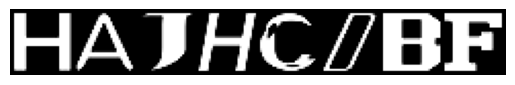

In [22]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
# plt.title(labels.detach().numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [23]:
class Flatten:
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + "()"

In [24]:
a = Flatten()

In [25]:
a(img).shape

torch.Size([784])

In [27]:
new_transform = torchvision.transforms.Compose([
#     torchvision.transforms.CenterCrop(),
#     torchvision.transforms.Resize((640, 460)),
    torchvision.transforms.ToTensor()
])

# Putting all together

In [28]:
import time

from IPython.display import clear_output

In [29]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [30]:
def subset_ind(dataset, ratio: float):
    #     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

In [32]:
dataset = DatasetMNIST(
    "./notMNIST_small",
#     'AB',
    transform=new_transform,
)

# shrink_inds = subset_ind(dataset, 0.2)
# dataset = Subset(dataset, shrink_inds)

# print(f"\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}")

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [33]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f"  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}")

  training size: 14980
validation size: 3744


In [35]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [36]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 1, 28, 28])
labels shape on batch size = torch.Size([32])


In [37]:
loss_func = nn.CrossEntropyLoss()

In [38]:
default_dtype = torch.float32

In [92]:
# create network again just in case
model = nn.Sequential(
    # nn.Linear(784, 10),
    nn.Conv2d(1, 8, (5, 5)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout2d(0.2),
    nn.Conv2d(8, 16, (5, 5)),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout2d(0.2),
    nn.Conv2d(16, 32, (3, 3)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.Flatten(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)
model.to(device, default_dtype)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [93]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    """
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    """
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)

            opt.zero_grad()
            loss.backward()

            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                # YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                # compute predictions
                # YOUR CODE HERE
                ep_val_loss.append(loss.item())  # YOUR CODE HERE
                y_pred = preds.max(-1)[1]  # YOUR CODE HERE
                ep_val_accuracy.append((y_pred == y_batch).to(default_dtype).mean().item())  # YOUR CODE HERE

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [94]:
out = model(images.to(device))

In [106]:
for g in opt.param_groups:
    g['lr'] = 1e-4

In [105]:
train_loss, val_loss, val_accuracy = [], [], []

In [107]:
n_epochs = 15


out = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 15 took 5.558s
	  training loss: 0.279264
	validation loss: 0.227242
	validation accuracy: 0.929
Epoch 2 of 15 took 6.312s
	  training loss: 0.263599
	validation loss: 0.223194
	validation accuracy: 0.931
Epoch 3 of 15 took 5.519s
	  training loss: 0.266105
	validation loss: 0.219340
	validation accuracy: 0.932
Epoch 4 of 15 took 6.499s
	  training loss: 0.261932
	validation loss: 0.218934
	validation accuracy: 0.933
Epoch 5 of 15 took 5.458s
	  training loss: 0.268518
	validation loss: 0.219397
	validation accuracy: 0.932
Epoch 6 of 15 took 6.141s
	  training loss: 0.255017
	validation loss: 0.217850
	validation accuracy: 0.933
Epoch 7 of 15 took 5.383s
	  training loss: 0.254286
	validation loss: 0.217382
	validation accuracy: 0.933
Epoch 8 of 15 took 6.989s
	  training loss: 0.262170
	validation loss: 0.218153
	validation accuracy: 0.933
Epoch 9 of 15 took 5.909s
	  training loss: 0.255213
	validation loss: 0.216843
	validation accuracy: 0.933
Epoch 10 of 15 took 6.128s
	

In [101]:
train_loss.extend(out[0]), val_loss.extend(out[1]), val_accuracy.extend(out[2])

(None, None, None)

In [110]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)

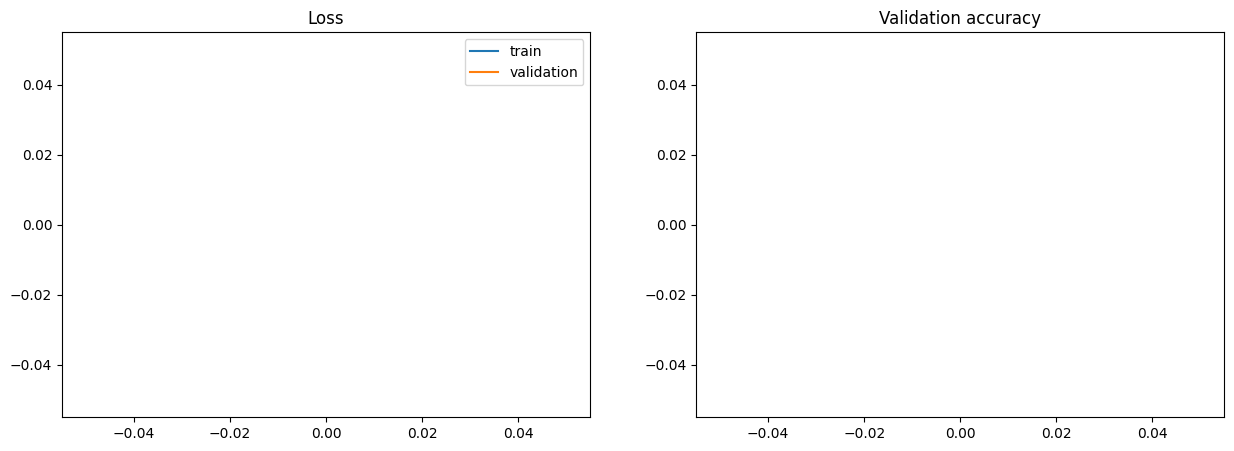

In [111]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [123]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print("model saved to %s" % checkpoint_path)


def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    print("model loaded from %s" % checkpoint_path)

In [114]:
model2 = nn.Sequential(
    # nn.Linear(784, 10),
    nn.Conv2d(1, 8, (5, 5)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout2d(0.2),
    nn.Conv2d(8, 16, (5, 5)),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout2d(0.2),
    nn.Conv2d(16, 32, (3, 3)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.Flatten(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

In [124]:
save_checkpoint('my_model.pth', model, opt)

model saved to my_model.pth


In [125]:
!ls

my_model.pth  notMNIST_small	     __pycache__  untar_notmnist.log
notmnist.py   notMNIST_small.tar.gz  sample_data


In [130]:
opt2 = torch.optim.Adam(model2.parameters())

In [131]:
load_checkpoint('my_model.pth', model2, opt2)

model loaded from my_model.pth


In [132]:
first_layer_params = next(model.parameters())

In [133]:
first_layer_params2 = next(model2.parameters())

In [134]:
torch.allclose(first_layer_params2, first_layer_params)

True

In [121]:
torch.allclose(torch.ones(10), torch.zeros(10)+1)

True

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        ep,
                        batch_idx * len(data),
                        len(trainset_loader.dataset),
                        100.0 * batch_idx / len(trainset_loader),
                        loss.item(),
                    )
                )
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)
            iteration += 1
        test()

    # save the final model
    save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint("mnist-4690.pth", model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)